In [ ]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import collections

# AdaFair class

In [ ]:
#Compute confusion matrix
from sklearn.metrics import confusion_matrix

#To calculate TRP and TNR for protected and non-protected groups, first separate them
def separate_protected_from_non_protected(y_true, y_pred, protected):
  y_true_protected = []
  y_pred_protected = []
  y_true_non_protected = []
  y_pred_non_protected = []
  for true_label, pred_label, is_protected in zip(y_true, y_pred, protected):
    if is_protected == 1:
      y_true_protected.append(true_label)
      y_pred_protected.append(pred_label)
    elif is_protected == 0:
      y_true_non_protected.append(true_label)
      y_pred_non_protected.append(pred_label)
    else:
      print("Error: invalid value of in protected array ", is_protected)
      return 0,0,0,0
  return (np.array(y_true_protected), np.array(y_pred_protected), np.array(y_true_non_protected), np.array(y_pred_non_protected))

def tp_tn_fp_fn(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    tp = matrix[1][1]
    tn = matrix[0][0]
    fp = matrix[0][1]
    fn = matrix[1][0]
    return (tp, tn, fp, fn)

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier # base classifier
from sklearn.ensemble import AdaBoostClassifier

#AdaFair implementation
class AdaFairClassifier(AdaBoostClassifier):
    def __init__(self,
                 base_estimator=None, *,
                 n_estimators=50,
                 learning_rate=1,
                 algorithm='SAMME',
                 random_state=42,
                 protected=None,
                 epsilon = 0):

        super().__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            algorithm = algorithm,
            learning_rate=learning_rate,
            random_state=random_state)
        self.n_estimators = n_estimators
        self.protected = np.array(protected)
        self.algorithm = algorithm
        self.epsilon = epsilon
    
    def _boost_discrete(self, iboost, X, y, sample_weight, random_state):
        """Implement a single boost using the SAMME discrete algorithm."""
        estimator = self._make_estimator(random_state=random_state)

        estimator.fit(X, y, sample_weight=sample_weight)

        y_predict = estimator.predict(X)
        y_predict_proba = estimator.predict_proba(X)
        #h_hat = np.argmax(y_predict_proba, axis = 0)
        h_hat = []
        for i in range(len(y_predict_proba)):
          #print (y_predict_proba[i])
          h_hat.append(y_predict_proba[i][np.argmax(y_predict_proba[i])])
          #y_predict[i] = np.argmax(h_hat[i])


        if iboost == 0:
            self.classes_ = getattr(estimator, 'classes_', None)
            self.n_classes_ = len(self.classes_)

        # Instances incorrectly classified
        incorrect = y_predict != y

        # Error fraction
        estimator_error = np.mean(
            np.average(incorrect, weights=sample_weight, axis=0))

        # Stop if classification is perfect
        if estimator_error <= 0:
            return sample_weight, 1., 0.

        n_classes = self.n_classes_

        # Stop if the error is at least as bad as random guessing
        if estimator_error >= 1. - (1. / n_classes):
            self.estimators_.pop(-1)
            if len(self.estimators_) == 0:
                raise ValueError('BaseClassifier in AdaBoostClassifier '
                                 'ensemble is worse than random, ensemble '
                                 'can not be fit.')
            return None, None, None

        if len(self.protected) != len(y):
          print ("Error: not given or given incorrect list of protected objects")
          return None, None, None

        #Compute fairness-related costs
        #CUMULATIVE prediction 
        
        y_cumulative_pred = list(self.staged_predict(X))[0]
        #for i in y_cumulative_pred:
        #  print(i)
        #print(y_cumulative_pred[0])
        u = np.array(self.get_fairness_related_costs(y, y_cumulative_pred, self.protected))

        # Boost weight using multi-class AdaBoost SAMME alg
        estimator_weight = self.learning_rate * (
            np.log((1. - estimator_error) / estimator_error) +
            np.log(n_classes - 1.))

        # Only boost the weights if I will fit again
        if not iboost == self.n_estimators - 1:
            # Only boost positive weights
            for i, weight in enumerate(sample_weight):
                sample_weight[i] = weight * np.exp(h_hat[i] * estimator_weight * incorrect[i] * (weight > 0)) * (1 + u[i])
            #sample_weight = sample_weight * np.exp(estimator_weight * incorrect * (sample_weight > 0)) * (np.ones(len(u)) + u)

        return sample_weight, estimator_weight, estimator_error

    def get_fairness_related_costs(self, y, y_pred_t, protected):        
        y_true_protected, y_pred_protected, y_true_non_protected, y_pred_non_protected = separate_protected_from_non_protected(y, y_pred_t, protected)
        #Rates for non protected group
        tp, tn, fp, fn = tp_tn_fp_fn(y_true_non_protected, y_pred_non_protected)
        FPR_non_protected = fp / (fp + tn)
        FNR_non_protected = fn / (fn + tp)
        #Rates for protected group
        tp, tn, fp, fn = tp_tn_fp_fn(y_true_protected, y_pred_protected)
        FPR_protected = fp / (fp + tn)
        FNR_protected = fn / (fn + tp)
        #ЭТО ТОЧНО МЕНЯТЬ УЖЕ НЕ НАДО
        delta_FPR = - FPR_non_protected + FPR_protected 
        delta_FNR = - FNR_non_protected + FNR_protected

        self.delta_FPR = delta_FPR
        self.delta_FNR = delta_FNR
        #Compute fairness related costs
        u = []
        for y_i, y_pred_t__i, protection  in zip(y, y_pred_t, protected):
            if y_i == 1 and y_pred_t__i == 0 and abs(delta_FNR) > self.epsilon and protection == 1 and delta_FNR > 0:
                u.append(abs(delta_FNR))
            elif y_i == 1 and y_pred_t__i == 0 and abs(delta_FNR) > self.epsilon and protection == 0 and delta_FNR < 0:
                u.append(abs(delta_FNR))
            elif y_i == 0 and y_pred_t__i == 1 and abs(delta_FPR) > self.epsilon and protection == 1 and delta_FPR > 0:
                u.append(abs(delta_FPR))
            elif y_i == 0 and y_pred_t__i == 1 and abs(delta_FPR) > self.epsilon and protection == 0 and delta_FPR < 0:
                u.append(abs(delta_FPR))
            else: u.append(0)
        return u


# Data Load

In [ ]:
def get_protected_instances(X, label, value):
  protected = []
  for i in range(len(X)):
    if X.iloc[i][label] == value:
      protected.append(1)
    else: protected.append(0)
  return protected

In [ ]:
#Adult census
#adult_census_names = ['old_id' ,'age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country']
X_train = pd.read_csv("splits/X_train_preprocessed_adult.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]
X_test = pd.read_csv("splits/X_test_preprocessed_adult.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]

y_train = pd.read_csv("splits/y_train_preprocessed_adult.csv")['income']
y_test = pd.read_csv("splits/y_test_preprocessed_adult.csv")['income']

#X_test, X_train = preprocess_adult_census(X_test.drop('old_id', axis = 1)), preprocess_adult_census(X_train.drop('old_id', axis = 1))
#y_test, y_train = adult_label_transform(y_test)['income'], adult_label_transform(y_train)['income']
#Obtain protected group (used in AdaFair)
protected_test = get_protected_instances(X_test, 'gender', 1)
protected_train = get_protected_instances(X_train, 'gender', 1)


In [ ]:
X_train = pd.read_csv("splits/X_train_preprocessed_bank.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]
X_test = pd.read_csv("splits/X_test_preprocessed_bank.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]

y_train = pd.read_csv("splits/y_train_preprocessed_bank.csv")['y']
y_test = pd.read_csv("splits/y_test_preprocessed_bank.csv")['y']
#reweight_prediction = "/content/predictions/y_pred_test_bank.csv"

#X_test, X_train = preprocess_adult_census(X_test.drop('old_id', axis = 1)), preprocess_adult_census(X_train.drop('old_id', axis = 1))
#y_test, y_train = adult_label_transform(y_test)['income'], adult_label_transform(y_train)['income']
#Obtain protected group (used in AdaFair)
protected_test = get_protected_instances(X_test, 'age', 1)
protected_train = get_protected_instances(X_train, 'age', 1)

In [ ]:
X_train = pd.read_csv("splits/X_train_preprocessed_compas.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]
X_test = pd.read_csv("splits/X_test_preprocessed_compas.csv").drop("Unnamed: 0", axis = 1)#, names = adult_census_names).iloc[1:]

y_train = pd.read_csv("splits/y_train_preprocessed_compas.csv")['two_year_recid']
y_test = pd.read_csv("splits/y_test_preprocessed_compas.csv")['two_year_recid']
#reweight_prediction = "/content/predictions/y_pred_test_bank.csv"

#X_test, X_train = preprocess_adult_census(X_test.drop('old_id', axis = 1)), preprocess_adult_census(X_train.drop('old_id', axis = 1))
#y_test, y_train = adult_label_transform(y_test)['income'], adult_label_transform(y_train)['income']
#Obtain protected group (used in AdaFair)
protected_test = get_protected_instances(X_test, 'race', 0)
protected_train = get_protected_instances(X_train, 'race', 0)

# Train and search

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

get_base_clf = lambda: DecisionTreeClassifier(max_depth = max_depth)


#AdaFair
max_depth = 2
n_estimators = 16
#Tolerance to unfairness
epsilon = 0

get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)

ada_fair = AdaFairClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators,
                                       protected = protected_train,
                                       epsilon = epsilon)

ada_fair.fit(X_train, y_train)

#Adaboost

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:758: RuntimeWarning: invalid value encountered in true_divide
  yield (tmp_pred / norm).sum(axis=1)


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

accuracy ada_fair: 0.4459300039323634
balanced accuracy ada_fair: 0.43426047079641605
accuracy ada_boost_sklearn: 0.6724341329138812
balanced accuracy ada_boost_sklearn: 0.6716201228706369
TPR protected ada_fair: 0.8894601542416453
TNR protected ada_fair: 0.06771653543307087
TPR non protected ada_fair: 0.0
TNR non protected ada_fair: 1.0
Eq. odds ada_fair:  1.8217436188085743 
TPR protected ada_boost_sklearn: 0.455012853470437
TNR protected ada_boost_sklearn: 0.8173228346456692
TPR non protected ada_boost_sklearn: 0.7661498708010336
TNR non protected ada_boost_sklearn: 0.5651006711409396
Eq. odds ada_boost_sklearn:  0.5633591808353262 


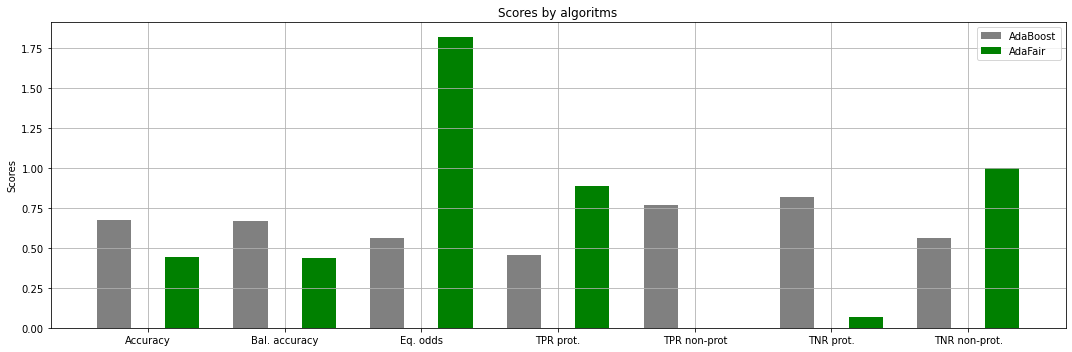

In [ ]:
#Compute accuracy metrics
from sklearn.metrics import balanced_accuracy_score

names = ['ada_fair','ada_boost_sklearn']
classifiers = [ada_fair, ada_boost_sklearn]

accuracy = {}
bal_accuracy = {}

# test ensemble classifier
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)
    accuracy[names[i]] = (prediction == y_test).sum() * 1. / len(y_test)
    bal_accuracy[names[i]] = balanced_accuracy_score(y_test, prediction)
    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test))) 
    print('balanced accuracy {}: {}'.format(names[i], balanced_accuracy_score(y_test, prediction))) 
c_protected_matrix_list = {}
c_matrix_list = {}

#for i, clf in enumerate(classifiers):
#    prediction = clf.predict(X_test)
#    y_true_protected, y_pred_protected, y_true_non_protected, y_pred_non_protected = separate_protected_from_non_protected(y_test, prediction, protected_test)
#    matrix = confusion_matrix(y_true_non_protected, y_pred_non_protected)
#    c_matrix_list[names[i] + " non_protected"] = matrix
#    matrix = confusion_matrix(y_true_protected, y_pred_protected) 
#    c_protected_matrix_list[names[i] + " protected"] = matrix

#print(c_matrix_list)

#print(c_protected_matrix_list)

#Compute TPR, FPR and Eq.odds
TPR = {}
TNR = {}
eq_odds = {}

for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)
    y_true_protected, y_pred_protected, y_true_non_protected, y_pred_non_protected = separate_protected_from_non_protected(y_test, prediction, protected_test)
    
    #TPR for protected group
    tp, tn, fp, fn = tp_tn_fp_fn(y_true_protected, y_pred_protected)
    TPR_protected = tp / (tp + fn)
    TNR_protected = tn / (tn + fp)
    FPR_protected = fp / (fp + tn)
    FNR_protected = fn / (fn + tp)
    print('TPR protected {}: {}'.format(names[i], TPR_protected))
    print('TNR protected {}: {}'.format(names[i], TNR_protected)) 

    TPR[names[i] + ' protected'] = TPR_protected
    TNR[names[i] + ' protected'] = TNR_protected

    #TPR for non protected group
    tp, tn, fp, fn = tp_tn_fp_fn(y_true_non_protected, y_pred_non_protected)
    TPR_non_protected = tp / (tp + fn)
    TNR_non_protected = tn / (tn + fp)
    FPR_non_protected = fp / (fp + tn)
    FNR_non_protected = fn / (fn + tp)
    print('TPR non protected {}: {}'.format(names[i], TPR_non_protected))
    print('TNR non protected {}: {}'.format(names[i], TNR_non_protected))
    #ЭТО ТОЧНО МЕНЯТЬ УЖЕ НЕ НАДО
    delta_FPR = - FPR_non_protected + FPR_protected
    delta_FNR = - FNR_non_protected + FNR_protected
    eq_odds[names[i]] = abs(delta_FPR) + abs(delta_FNR)
    print('Eq. odds {}:  {} '.format(names[i], eq_odds[names[i]]))

    TPR[names[i] + ' non protected'] = TPR_non_protected
    TNR[names[i] + ' non protected'] = TNR_non_protected

# Plot results in a group bar chart (https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Accuracy', 'Bal. accuracy', 'Eq. odds','TPR prot.', 'TPR non-prot', 'TNR prot.', 'TNR non-prot.']
adaFair_metrics = [accuracy['ada_fair'], bal_accuracy['ada_fair'], eq_odds['ada_fair'], TPR['ada_fair protected'], TPR['ada_fair non protected'], TNR['ada_fair protected'], TNR['ada_fair non protected']]
adaBoost_metrics = [accuracy['ada_boost_sklearn'], bal_accuracy['ada_boost_sklearn'], eq_odds['ada_boost_sklearn'], TPR['ada_boost_sklearn protected'], TPR['ada_boost_sklearn non protected'], TNR['ada_boost_sklearn protected'], TNR['ada_boost_sklearn non protected']]


x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = [15, 5])
rects1 = ax.bar(x - width, adaBoost_metrics, width, label='AdaBoost', color='gray')
rects3 = ax.bar(x + width, adaFair_metrics, width, label='AdaFair', color='green')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by algoritms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid()
fig.tight_layout()

plt.show()



In [ ]:
#Now we will run a grid-search over the following hyperparameters: max_depth, n_estimators

def compute_metrics(classifiers, X_test, y_test, protected_test):
    names = ['ada_fair','ada_boost_sklearn']

    accuracy = {}
    bal_accuracy = {}
    c_protected_matrix_list = {} #?
    c_matrix_list = {}

    #Compute TPR, FPR and Eq.odds
    TPR = {}
    TNR = {}
    eq_odds = {}
    # test ensemble classifier
    for i, clf in enumerate(classifiers):
        prediction = clf.predict(X_test)
        accuracy[names[i]] = (prediction == y_test).sum() * 1. / len(y_test)
        bal_accuracy[names[i]] = balanced_accuracy_score(y_test, prediction)
        #print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test))) 
        #print('balanced accuracy {}: {}'.format(names[i], balanced_accuracy_score(y_test, prediction))) 
        y_true_protected, y_pred_protected, y_true_non_protected, y_pred_non_protected = separate_protected_from_non_protected(y_test, prediction, protected_test)
        
        #TPR for protected group
        tp, tn, fp, fn = tp_tn_fp_fn(y_true_protected, y_pred_protected)
        TPR_protected = tp / (tp + fn)
        TNR_protected = tn / (tn + fp)
        FPR_protected = fp / (fp + tn)
        FNR_protected = fn / (fn + tp)
        #print('TPR protected {}: {}'.format(names[i], TPR_protected))
        #print('TNR protected {}: {}'.format(names[i], TNR_protected)) 

        TPR[names[i] + ' protected'] = TPR_protected
        TNR[names[i] + ' protected'] = TNR_protected

        #TPR for non protected group
        tp, tn, fp, fn = tp_tn_fp_fn(y_true_non_protected, y_pred_non_protected)
        TPR_non_protected = tp / (tp + fn)
        TNR_non_protected = tn / (tn + fp)
        FPR_non_protected = fp / (fp + tn)
        FNR_non_protected = fn / (fn + tp)
        #print('TPR non protected {}: {}'.format(names[i], TPR_non_protected))
        #print('TNR non protected {}: {}'.format(names[i], TNR_non_protected))

        delta_FPR = -FPR_non_protected + FPR_protected
        delta_FNR = -FNR_non_protected + FNR_protected
        eq_odds[names[i]] = abs(delta_FPR) + abs(delta_FNR)

        TPR[names[i] + ' non protected'] = TPR_non_protected
        TNR[names[i] + ' non protected'] = TNR_non_protected
    return (accuracy, bal_accuracy, eq_odds, TPR, TNR)

def search(max_depth_list = [2,3,4,5], n_estimators_list = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]):
  metrics = []
  for max_depth in max_depth_list:
    metrics.append([])
    for n_estimators in n_estimators_list:
      #Tolerance to unfairness
      epsilon = 0
      get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)
      ada_fair = AdaFairClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators,
                                       protected = protected_train,
                                       epsilon = epsilon)

      ada_fair.fit(X_train, y_train)
      ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

      ada_boost_sklearn.fit(X_train, y_train)
      classifiers = [ada_fair, ada_boost_sklearn]
      metrics[-1].append(compute_metrics(classifiers, X_test, y_test, protected_test))
  return (metrics)

metrics = search()

      

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:758: RuntimeWarning: invalid value encountered in true_divide
  yield (tmp_pred / norm).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:758: RuntimeWarning: invalid value encountered in true_divide
  yield (tmp_pred / norm).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:758: RuntimeWarning: invalid value encountered in true_divide
  yield (tmp_pred / norm).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:758: RuntimeWarning: invalid value encountered in true_divide
  yield (tmp_pred / norm).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:758: RuntimeWarning: invalid value encountered in true_divide
  yield (tmp_pred / norm).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:758: RuntimeWarning: invalid value encounter

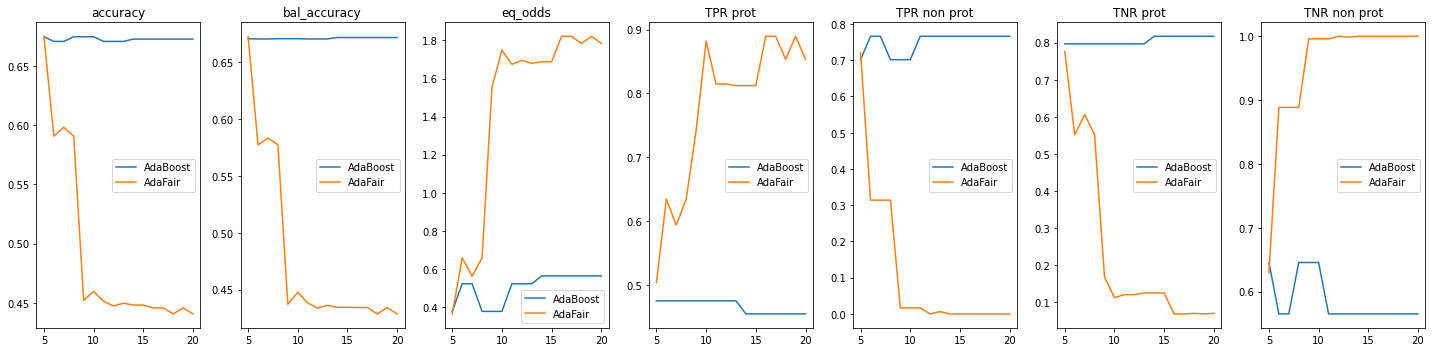

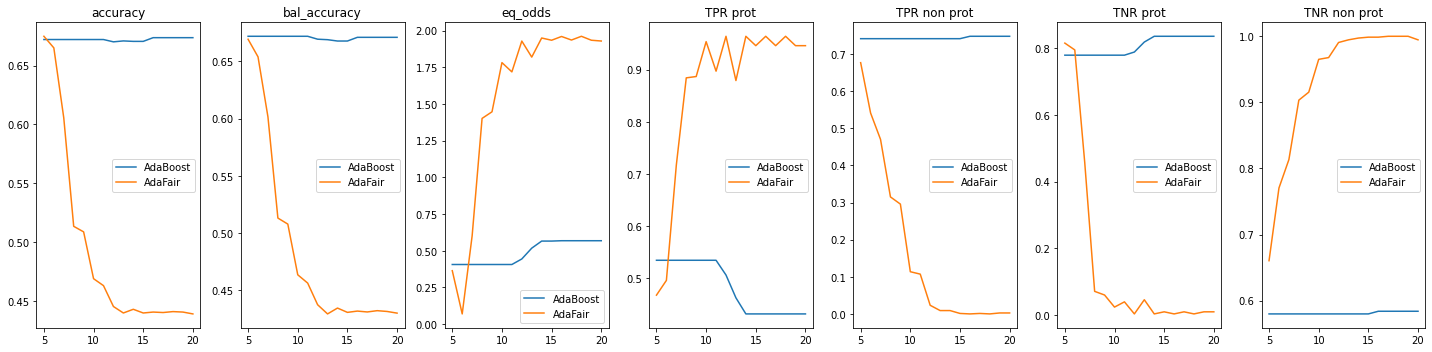

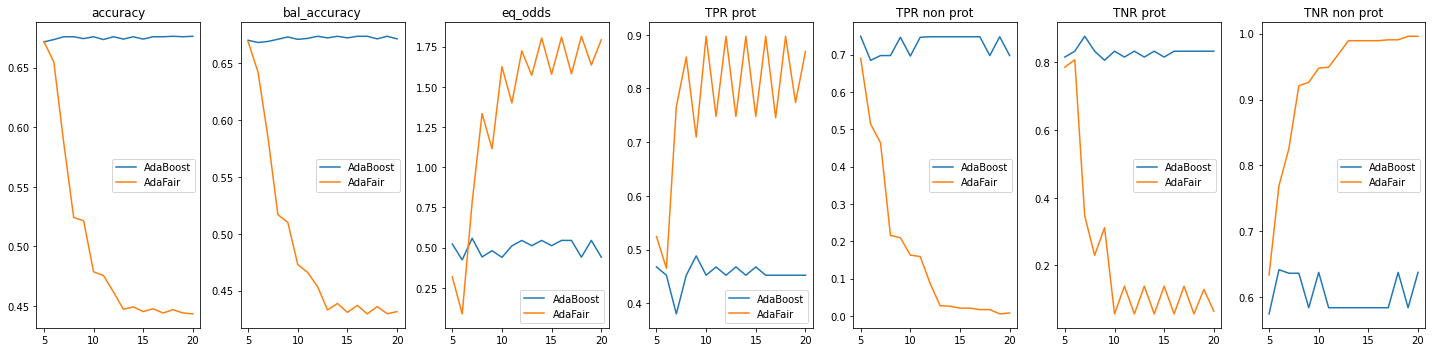

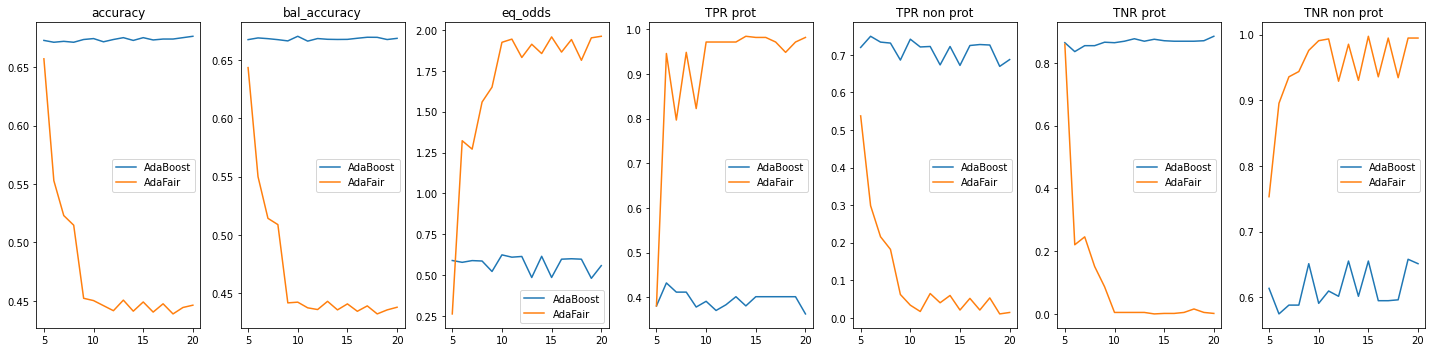

In [ ]:

#------max_depth-n_estimators-metric------model----------
metrics   [0]        [0]       [0]  ['ada_boost_sklearn']
titles = ['accuracy', 'bal_accuracy', 'eq_odds', 'TPR prot','TPR non prot', 'TNR prot', 'TNR non prot']
fig, ax = plt.subplots(1,7, figsize = [20,5])
xx = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
#----------Get metrics for max_est = 2-------------------
#Max_est = 2 metrics for adaboost_sklearn:
accuracy_max_d_2_sklearn_by_n_est = []
bal_accuracy_max_d_2_sklearn_by_n_est = []
eq_odds_max_d_2_sklearn_by_n_est = []
TPR_prot_max_d_2_sklearn_by_n_est = [] 
TPR_non_prot_max_d_2_sklearn_by_n_est = []
TNR_prot_max_d_2_sklearn_by_n_est = [] 
TNR_non_prot_max_d_2_sklearn_by_n_est = []

#Max_est = 2 metrics for adaFair:
accuracy_max_d_2_fair_by_n_est = []
bal_accuracy_max_d_2_fair_by_n_est = []
eq_odds_max_d_2_fair_by_n_est = []
TPR_prot_max_d_2_fair_by_n_est = [] 
TPR_non_prot_max_d_2_fair_by_n_est = []
TNR_prot_max_d_2_fair_by_n_est = [] 
TNR_non_prot_max_d_2_fair_by_n_est = []

for metric in metrics[0]:
  accuracy_max_d_2_sklearn_by_n_est.append(metric[0]['ada_boost_sklearn'])
  bal_accuracy_max_d_2_sklearn_by_n_est.append(metric[1]['ada_boost_sklearn'])
  eq_odds_max_d_2_sklearn_by_n_est.append(metric[2]['ada_boost_sklearn'])
  TPR_prot_max_d_2_sklearn_by_n_est.append(metric[3]['ada_boost_sklearn protected'])
  TPR_non_prot_max_d_2_sklearn_by_n_est.append(metric[3]['ada_boost_sklearn non protected'])
  TNR_prot_max_d_2_sklearn_by_n_est.append(metric[4]['ada_boost_sklearn protected'])
  TNR_non_prot_max_d_2_sklearn_by_n_est.append(metric[4]['ada_boost_sklearn non protected'])

  accuracy_max_d_2_fair_by_n_est.append(metric[0]['ada_fair'])
  bal_accuracy_max_d_2_fair_by_n_est.append(metric[1]['ada_fair'])
  eq_odds_max_d_2_fair_by_n_est.append(metric[2]['ada_fair'])
  TPR_prot_max_d_2_fair_by_n_est.append(metric[3]['ada_fair protected'])
  TPR_non_prot_max_d_2_fair_by_n_est.append(metric[3]['ada_fair non protected'])
  TNR_prot_max_d_2_fair_by_n_est.append(metric[4]['ada_fair protected'])
  TNR_non_prot_max_d_2_fair_by_n_est.append(metric[4]['ada_fair non protected'])

ax[0].plot(xx,accuracy_max_d_2_sklearn_by_n_est,label = 'AdaBoost')
ax[0].plot(xx,accuracy_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[1].plot(xx,bal_accuracy_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[1].plot(xx,bal_accuracy_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[2].plot(xx,eq_odds_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[2].plot(xx,eq_odds_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[3].plot(xx,TPR_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[3].plot(xx,TPR_prot_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[4].plot(xx,TPR_non_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[4].plot(xx,TPR_non_prot_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[5].plot(xx,TNR_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[5].plot(xx,TNR_prot_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[6].plot(xx,TNR_non_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[6].plot(xx,TNR_non_prot_max_d_2_fair_by_n_est, label = 'AdaFair')
for a,title in zip(ax, titles):
  a.legend()
  a.set_title(title)
#ax[0].ylabel('Accuracy')
#ax[0].xlabel('n_estimators')
plt.tight_layout()
plt.show()


#----------Get metrics for max_est = 3-------------------
fig, ax = plt.subplots(1,7, figsize = [20,5])
#Max_est = 3 metrics for adaboost_sklearn:
accuracy_max_d_2_sklearn_by_n_est = []
bal_accuracy_max_d_2_sklearn_by_n_est = []
eq_odds_max_d_2_sklearn_by_n_est = []
TPR_prot_max_d_2_sklearn_by_n_est = [] 
TPR_non_prot_max_d_2_sklearn_by_n_est = []
TNR_prot_max_d_2_sklearn_by_n_est = [] 
TNR_non_prot_max_d_2_sklearn_by_n_est = []

#Max_est = 3 metrics for adaFair:
accuracy_max_d_2_fair_by_n_est = []
bal_accuracy_max_d_2_fair_by_n_est = []
eq_odds_max_d_2_fair_by_n_est = []
TPR_prot_max_d_2_fair_by_n_est = [] 
TPR_non_prot_max_d_2_fair_by_n_est = []
TNR_prot_max_d_2_fair_by_n_est = [] 
TNR_non_prot_max_d_2_fair_by_n_est = []

for metric in metrics[1]:
  accuracy_max_d_2_sklearn_by_n_est.append(metric[0]['ada_boost_sklearn'])
  bal_accuracy_max_d_2_sklearn_by_n_est.append(metric[1]['ada_boost_sklearn'])
  eq_odds_max_d_2_sklearn_by_n_est.append(metric[2]['ada_boost_sklearn'])
  TPR_prot_max_d_2_sklearn_by_n_est.append(metric[3]['ada_boost_sklearn protected'])
  TPR_non_prot_max_d_2_sklearn_by_n_est.append(metric[3]['ada_boost_sklearn non protected'])
  TNR_prot_max_d_2_sklearn_by_n_est.append(metric[4]['ada_boost_sklearn protected'])
  TNR_non_prot_max_d_2_sklearn_by_n_est.append(metric[4]['ada_boost_sklearn non protected'])

  accuracy_max_d_2_fair_by_n_est.append(metric[0]['ada_fair'])
  bal_accuracy_max_d_2_fair_by_n_est.append(metric[1]['ada_fair'])
  eq_odds_max_d_2_fair_by_n_est.append(metric[2]['ada_fair'])
  TPR_prot_max_d_2_fair_by_n_est.append(metric[3]['ada_fair protected'])
  TPR_non_prot_max_d_2_fair_by_n_est.append(metric[3]['ada_fair non protected'])
  TNR_prot_max_d_2_fair_by_n_est.append(metric[4]['ada_fair protected'])
  TNR_non_prot_max_d_2_fair_by_n_est.append(metric[4]['ada_fair non protected'])


ax[0].plot(xx,accuracy_max_d_2_sklearn_by_n_est,label = 'AdaBoost')
ax[0].plot(xx,accuracy_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[1].plot(xx,bal_accuracy_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[1].plot(xx,bal_accuracy_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[2].plot(xx,eq_odds_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[2].plot(xx,eq_odds_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[3].plot(xx,TPR_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[3].plot(xx,TPR_prot_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[4].plot(xx,TPR_non_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[4].plot(xx,TPR_non_prot_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[5].plot(xx,TNR_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[5].plot(xx,TNR_prot_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[6].plot(xx,TNR_non_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[6].plot(xx,TNR_non_prot_max_d_2_fair_by_n_est, label = 'AdaFair')
for a,title in zip(ax, titles):
  a.legend()
  a.set_title(title)
plt.tight_layout()
plt.show()

#----------Get metrics for max_est = 4-------------------
fig, ax = plt.subplots(1,7, figsize = [20,5])
#Max_est = 3 metrics for adaboost_sklearn:
accuracy_max_d_2_sklearn_by_n_est = []
bal_accuracy_max_d_2_sklearn_by_n_est = []
eq_odds_max_d_2_sklearn_by_n_est = []
TPR_prot_max_d_2_sklearn_by_n_est = [] 
TPR_non_prot_max_d_2_sklearn_by_n_est = []
TNR_prot_max_d_2_sklearn_by_n_est = [] 
TNR_non_prot_max_d_2_sklearn_by_n_est = []

#Max_est = 3 metrics for adaFair:
accuracy_max_d_2_fair_by_n_est = []
bal_accuracy_max_d_2_fair_by_n_est = []
eq_odds_max_d_2_fair_by_n_est = []
TPR_prot_max_d_2_fair_by_n_est = [] 
TPR_non_prot_max_d_2_fair_by_n_est = []
TNR_prot_max_d_2_fair_by_n_est = [] 
TNR_non_prot_max_d_2_fair_by_n_est = []

for metric in metrics[2]:
  accuracy_max_d_2_sklearn_by_n_est.append(metric[0]['ada_boost_sklearn'])
  bal_accuracy_max_d_2_sklearn_by_n_est.append(metric[1]['ada_boost_sklearn'])
  eq_odds_max_d_2_sklearn_by_n_est.append(metric[2]['ada_boost_sklearn'])
  TPR_prot_max_d_2_sklearn_by_n_est.append(metric[3]['ada_boost_sklearn protected'])
  TPR_non_prot_max_d_2_sklearn_by_n_est.append(metric[3]['ada_boost_sklearn non protected'])
  TNR_prot_max_d_2_sklearn_by_n_est.append(metric[4]['ada_boost_sklearn protected'])
  TNR_non_prot_max_d_2_sklearn_by_n_est.append(metric[4]['ada_boost_sklearn non protected'])

  accuracy_max_d_2_fair_by_n_est.append(metric[0]['ada_fair'])
  bal_accuracy_max_d_2_fair_by_n_est.append(metric[1]['ada_fair'])
  eq_odds_max_d_2_fair_by_n_est.append(metric[2]['ada_fair'])
  TPR_prot_max_d_2_fair_by_n_est.append(metric[3]['ada_fair protected'])
  TPR_non_prot_max_d_2_fair_by_n_est.append(metric[3]['ada_fair non protected'])
  TNR_prot_max_d_2_fair_by_n_est.append(metric[4]['ada_fair protected'])
  TNR_non_prot_max_d_2_fair_by_n_est.append(metric[4]['ada_fair non protected'])


ax[0].plot(xx,accuracy_max_d_2_sklearn_by_n_est,label = 'AdaBoost')
ax[0].plot(xx,accuracy_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[1].plot(xx,bal_accuracy_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[1].plot(xx,bal_accuracy_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[2].plot(xx,eq_odds_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[2].plot(xx,eq_odds_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[3].plot(xx,TPR_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[3].plot(xx,TPR_prot_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[4].plot(xx,TPR_non_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[4].plot(xx,TPR_non_prot_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[5].plot(xx,TNR_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[5].plot(xx,TNR_prot_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[6].plot(xx,TNR_non_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[6].plot(xx,TNR_non_prot_max_d_2_fair_by_n_est, label = 'AdaFair')
for a,title in zip(ax, titles):
  a.legend()
  a.set_title(title)
plt.tight_layout()
plt.show()

#----------Get metrics for max_est = 4-------------------
fig, ax = plt.subplots(1,7, figsize = [20,5])
#Max_est = 3 metrics for adaboost_sklearn:
accuracy_max_d_2_sklearn_by_n_est = []
bal_accuracy_max_d_2_sklearn_by_n_est = []
eq_odds_max_d_2_sklearn_by_n_est = []
TPR_prot_max_d_2_sklearn_by_n_est = [] 
TPR_non_prot_max_d_2_sklearn_by_n_est = []
TNR_prot_max_d_2_sklearn_by_n_est = [] 
TNR_non_prot_max_d_2_sklearn_by_n_est = []

#Max_est = 3 metrics for adaFair:
accuracy_max_d_2_fair_by_n_est = []
bal_accuracy_max_d_2_fair_by_n_est = []
eq_odds_max_d_2_fair_by_n_est = []
TPR_prot_max_d_2_fair_by_n_est = [] 
TPR_non_prot_max_d_2_fair_by_n_est = []
TNR_prot_max_d_2_fair_by_n_est = [] 
TNR_non_prot_max_d_2_fair_by_n_est = []

for metric in metrics[3]:
  accuracy_max_d_2_sklearn_by_n_est.append(metric[0]['ada_boost_sklearn'])
  bal_accuracy_max_d_2_sklearn_by_n_est.append(metric[1]['ada_boost_sklearn'])
  eq_odds_max_d_2_sklearn_by_n_est.append(metric[2]['ada_boost_sklearn'])
  TPR_prot_max_d_2_sklearn_by_n_est.append(metric[3]['ada_boost_sklearn protected'])
  TPR_non_prot_max_d_2_sklearn_by_n_est.append(metric[3]['ada_boost_sklearn non protected'])
  TNR_prot_max_d_2_sklearn_by_n_est.append(metric[4]['ada_boost_sklearn protected'])
  TNR_non_prot_max_d_2_sklearn_by_n_est.append(metric[4]['ada_boost_sklearn non protected'])

  accuracy_max_d_2_fair_by_n_est.append(metric[0]['ada_fair'])
  bal_accuracy_max_d_2_fair_by_n_est.append(metric[1]['ada_fair'])
  eq_odds_max_d_2_fair_by_n_est.append(metric[2]['ada_fair'])
  TPR_prot_max_d_2_fair_by_n_est.append(metric[3]['ada_fair protected'])
  TPR_non_prot_max_d_2_fair_by_n_est.append(metric[3]['ada_fair non protected'])
  TNR_prot_max_d_2_fair_by_n_est.append(metric[4]['ada_fair protected'])
  TNR_non_prot_max_d_2_fair_by_n_est.append(metric[4]['ada_fair non protected'])


ax[0].plot(xx,accuracy_max_d_2_sklearn_by_n_est,label = 'AdaBoost')
ax[0].plot(xx,accuracy_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[1].plot(xx,bal_accuracy_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[1].plot(xx,bal_accuracy_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[2].plot(xx,eq_odds_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[2].plot(xx,eq_odds_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[3].plot(xx,TPR_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[3].plot(xx,TPR_prot_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[4].plot(xx,TPR_non_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[4].plot(xx,TPR_non_prot_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[5].plot(xx,TNR_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[5].plot(xx,TNR_prot_max_d_2_fair_by_n_est, label = 'AdaFair')

ax[6].plot(xx,TNR_non_prot_max_d_2_sklearn_by_n_est, label="AdaBoost")
ax[6].plot(xx,TNR_non_prot_max_d_2_fair_by_n_est, label = 'AdaFair')
for a,title in zip(ax, titles):
  a.legend()
  a.set_title(title)

plt.tight_layout()
plt.show()